In [57]:
%run Data_Analysis_Functions.ipynb

In [98]:
path = 'C:\BackupFYPData\TestsReport\Test2'
test = 'Test2'

# Read in all the data
households = pd.read_csv(f"{path}\Households.csv").sort_index(axis=1)
cons_firms = pd.read_csv(f"{path}\Consumer_Firms.csv").sort_index(axis=1)
cap_firms = pd.read_csv(f"{path}\Capital_Firms.csv").sort_index(axis=1)
pboard = pd.read_csv(f"{path}\Public_Info_Board.csv").sort_index(axis=1)
bank = pd.read_csv(f"{path}\Bank.csv").sort_index(axis=1)


In [99]:
mask = households['date'].apply(lambda x: np.isnan(x) if isinstance(x, float) else False)

# filter dataframe using mask
filtered_df = households[mask]

timestep = int(households['date'].max())
#timestep = 15
n_households = households[households.date == 0].shape[0]
n_cons_firms = cons_firms[cons_firms.date == 0].shape[0]
n_cap_firms = cap_firms[cap_firms.date == 0].shape[0]
t = np.linspace(0,timestep, timestep +1) 
print(f"Program has {n_households} households, {n_cons_firms} consumer firms, {n_cap_firms} capital firms, and runs for {timestep} timesteps")

Program has 5000 households, 150 consumer firms, 25 capital firms, and runs for 60 timesteps


Get sums and averages for each timestep

In [100]:
households_sum = households.groupby('date').sum().reset_index()
households_avg = households.groupby('date').mean().reset_index()
cons_firms_sum = cons_firms.groupby('date').sum().reset_index()
cons_firms_avg = cons_firms.groupby('date').mean().reset_index()
cap_firms_sum = cap_firms.groupby('date').sum().reset_index()
cap_firms_avg = cap_firms.groupby('date').mean().reset_index()

# Separate households into workers or firm owners and caclulate sums and averages
# Get id of households who are firm owners
firm_owner_ids = households[(households['date'] == 0) & (households['firm_owner'] == 1)]['id'].tolist()
households_workers = households[~households['id'].isin(firm_owner_ids)]
households_owners = households[households['id'].isin(firm_owner_ids)]

households_workers_avg = households_workers.groupby('date').mean().reset_index()
households_workers_sum = households_workers.groupby('date').sum().reset_index()
households_owners_avg = households_owners.groupby('date').mean().reset_index()
households_owners_sum = households_owners.groupby('date').sum().reset_index()

# Calculate the average of incomes for the firm owners appropriately
n_firm_owners = n_cap_firms + n_cons_firms
firm_owner_sum = households_owners.groupby('date')['firm_owner'].sum()
households_owners_avg.loc[:, 'income_dividend_average'] = households_owners.groupby('date')['income_dividend'].sum() / firm_owner_sum.values
households_owners_avg.loc[:, 'income_wage_average'] = households_owners.groupby('date')['income_wage'].sum() / (n_firm_owners - firm_owner_sum.values)

Minor data fixes

In [101]:
bank["cons_inflation_current"] = bank["cons_inflation_current"] - 1


In [102]:
# correctly calculate bankruptcies
pboard["bankruptcies"] = (pboard["p_bankrupt_cons_firms"] * n_cons_firms + pboard["p_bankrupt_cap_firms"] * n_cap_firms) / (n_cons_firms + n_cap_firms)

Delete the original dataframes to free memory (we use the avg and sums)

In [103]:
#del households
#del cons_firms
#del cap_firms

Copy sector data to separate dataframe

In [104]:
sector_data = pd.DataFrame({'date': t})

sector_data = pd.concat([sector_data, pboard.filter(regex='actual_spending_on_sector')], axis=1 )
sector_data = pd.concat([sector_data, pboard.filter(regex='planned_spending_on_sector')], axis=1 )
sector_data = pd.concat([sector_data, pboard.filter(regex='actual_production_on_sector')], axis=1 )
sector_data = pd.concat([sector_data, pboard.filter(regex='planned_production_on_sector')], axis=1 )
sector_data = pd.concat([sector_data, pboard.filter(regex='inventory_by_sector')], axis=1 )
sector_data = pd.concat([sector_data, pboard.filter(regex='quantity_sold_by_sector')], axis=1 )
sector_data = pd.concat([sector_data, pboard.filter(regex='total_cons_emissions_by_sector')], axis=1 )
sector_data = pd.concat([sector_data, pboard.filter(regex='total_firm_emissions_by_sector')], axis=1 )
sector_data = pd.concat([sector_data, pboard.filter(regex='offsets_sold_by_sector')], axis=1 )
sector_data = pd.concat([sector_data, pboard.filter(regex='price_level_cons_sector')], axis=1 )


for i in range(12):
    sector_data[f"real_spending_on_sector_{i}"] = sector_data[f"actual_spending_on_sector_{i}"] / sector_data[f"price_level_cons_sector_{i}"]
    sector_data[f"real_spending_growth_on_sector_{i}"] = sector_data[f"real_spending_on_sector_{i}"].pct_change()

for i in range(12):
    sector_data[f"average_unit_emissions_by_sector_{i}"] = sector_data[f"total_cons_emissions_by_sector_{i}"] / sector_data[f"inventory_by_sector_{i}"]

Calculate new useful sector data

In [105]:
for i in range (0,12):
    sector_data[f"actual_spending_on_sector_{i}_real"] = sector_data[f"actual_spending_on_sector_{i}"] / sector_data[f"price_level_cons_sector_{i}"]
    sector_data[f"planned_spending_on_sector_{i}_real"] = sector_data[f"planned_spending_on_sector_{i}"] / sector_data[f"price_level_cons_sector_{i}"]

Drop sector columns from public board, and store aggreagate data

In [106]:
pboard = pboard.drop(columns=pboard.filter(regex='actual_spending_on_sector').columns)
pboard = pboard.drop(columns=pboard.filter(regex='planned_spending_on_sector').columns)
pboard = pboard.drop(columns=pboard.filter(regex='actual_production_on_sector').columns)
pboard = pboard.drop(columns=pboard.filter(regex='planned_production_on_sector').columns)
pboard = pboard.drop(columns=pboard.filter(regex='inventory_by_sector').columns)
pboard = pboard.drop(columns=pboard.filter(regex='quantity_sold_by_sector').columns)
pboard = pboard.drop(columns=pboard.filter(regex='total_cons_emissions_by_sector').columns)
pboard = pboard.drop(columns=pboard.filter(regex='total_firm_emissions_by_sector').columns)
pboard = pboard.drop(columns=pboard.filter(regex='offsets_sold_by_sector').columns)
pboard = pboard.drop(columns=pboard.filter(regex='price_level_cons_sector').columns)

actual_spending = sector_data.filter(regex='actual_spending_on_sector')
pboard['total_actual_spending'] = actual_spending.sum(axis=1)
planned_spending = sector_data.filter(regex='planned_spending_on_sector')
pboard['total_planned_spending'] = planned_spending.sum(axis=1)
pboard = pboard.drop(columns=pboard.filter(regex='planned_spending_on_sector').columns)
inventory = sector_data.filter(regex='inventory_by_sector')
pboard['total_inventory'] = inventory.sum(axis=1)
planned_production = sector_data.filter(regex='planned_production_on_sector')
pboard['total_planned_production'] = planned_production.sum(axis=1)
actual_production = sector_data.filter(regex='actual_production_on_sector')
pboard['total_actual_production'] = actual_production.sum(axis=1)
quantity_sold = sector_data.filter(regex='quantity_sold_by_sector')
pboard['total_quantity_sold'] = quantity_sold.sum(axis=1)
total_cons_emissions = sector_data.filter(regex='total_cons_emissions_by_sector')
pboard['total_cons_emissions'] = total_cons_emissions.sum(axis=1)
total_firm_emissions = sector_data.filter(regex='total_firm_emissions_by_sector')
pboard['total_firm_emissions'] = total_firm_emissions.sum(axis=1)
offsets_sold = sector_data.filter(regex='offsets_sold_by_sector')
pboard['total_offsets_sold'] = offsets_sold.sum(axis=1)

Calculate other useful data for public board

In [107]:
pboard['cons_production_shortfall'] = pboard['total_planned_production'] - pboard['total_actual_production']
pboard['cap_production_shortfall'] = pboard['cap_goods_production_planned'] - pboard['cap_goods_production']

Calculate useful economic data and store these in the economy dataframe

In [108]:
economy = pd.DataFrame({'date': t})

# Total cons spending and growth , real and nominal
economy['cons_spending_nominal'] = pboard['total_actual_spending']
economy['cons_spending_real'] = pboard['total_actual_spending'] / pboard['price_level_current']

economy['cons_spending_growth_nominal'] = pboard['total_actual_spending'].pct_change() * 100
economy["cons_spending_growth_real"] = economy['cons_spending_real'].pct_change() * 100

# Cons sending shortfall
economy["cons_spending_shortfall"] = pboard["total_planned_spending"] - pboard["total_actual_spending"] 

# Capital Spending
economy['cap_spending_nominal'] = pboard['capital_spending']
economy['cap_spending_real'] = pboard['capital_spending'] / pboard['cap_price_level_current']

economy['cap_spending_growth_nominal'] = economy['cap_spending_nominal'].pct_change() * 100
economy['cap_spending_growth_real'] = economy['cap_spending_real'].pct_change() * 100

# Capital spending shortfall
economy["cap_spending_shortfall"] = pboard["machine_spending_planned"] - pboard["capital_spending"] 


# GDP Figures
economy['GDP_nominal'] = economy['cons_spending_nominal'] + economy['cap_spending_nominal'] + cap_firms_sum['tax_payments'] + cons_firms_sum['tax_payments']
economy['GDP_real'] = economy["cons_spending_real"] + economy['cap_spending_real'] + (cap_firms_sum['tax_payments'] + cons_firms_sum['tax_payments'])/pboard['price_level_current']

economy['GDP_growth_nominal'] = economy['GDP_nominal'].pct_change() * 100
economy['GDP_growth_real'] = economy['GDP_real'].pct_change() * 100


# set first growth figures to 0
economy.loc[:1, 'cons_spending_growth_nominal'] = 0
economy.loc[:1, 'cons_spending_growth_real'] = 0
economy.loc[:1, 'GDP_growth_nominal'] = 0
economy.loc[:1, 'GDP_growth_real'] = 0
economy.loc[:1, 'cap_spending_growth_nominal'] = 0
economy.loc[:1, 'cap_spending_growth_real'] = 0


<Figure size 800x600 with 0 Axes>

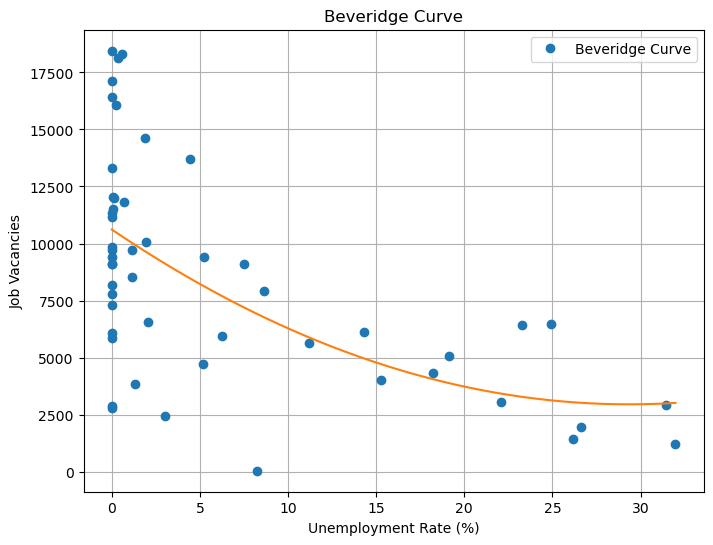

In [113]:
plt.figure(figsize=(8, 6))

start_time = 0
end_time = 60

df = pd.DataFrame({
    "Job Vacancies": pboard.loc[(pboard["date"] > start_time) & (pboard["date"] < end_time), "n_active_job_postings"],
    "Unemployment Rate": pboard.loc[(pboard["date"] > start_time) & (pboard["date"] < end_time), "unemp_rate"],
})

# Filter to show the best fit


# Fillter for low or high unemployment
df = df[(df["Unemployment Rate"] >= 0) & ((df["Unemployment Rate"] < 1)) ]

# Filter for low or high vacancies
df = df[(df["Job Vacancies"] >= 0) & (df["Job Vacancies"] < 20000) ]


df["Unemployment Rate"] = df["Unemployment Rate"] * 100

plt.figure(figsize=(8, 6))
plt.plot(df["Unemployment Rate"], df["Job Vacancies"], 'o', label='Beveridge Curve')
plt.xlabel('Unemployment Rate (%)')
plt.ylabel('Job Vacancies')
plt.title('Beveridge Curve')
plt.legend()
plt.grid(True)

# Fit a degree-2 polynomial to the data
coefficients = np.polyfit(df["Unemployment Rate"], df["Job Vacancies"], 2)
poly = np.poly1d(coefficients)
# plot the fitted polynomial
x_values = np.linspace(min(df["Unemployment Rate"]), max(df["Unemployment Rate"]), 500)
y_values = poly(x_values)
plt.plot(x_values, y_values, '-', label='Fitted curve')




plt.savefig(f"{path}\Beveridge_curve_{test}.png", dpi=600)

plt.show()


Sumary plot

In [95]:
import seaborn as sns

def plot_columns(n_rows=2, name="composite_plot", *args):
    # Calculate the number of columns based on the number of rows
    n_cols = np.ceil(len(args) / (2 * n_rows)).astype(int)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 8))  # Create subplots
    axes = axes.flatten()  # Flatten the axes object to easily iterate over it

    for i in range(0, len(args), 2):
        df = args[i]
        col_name = args[i + 1]

        # Plot the column data with label
        sns.lineplot(data=df[col_name], ax=axes[i // 2], color='C' + str(i // 2))

        # Set y label as column name
        axes[i // 2].set_ylabel(col_name)

        # Set x label as time
        axes[i // 2].set_xlabel('Time')

        # Set plot title as column name
        axes[i // 2].set_title(col_name.capitalize())

        # Add grid lines
        axes[i // 2].grid(True)

    # If there are fewer plots than total subplots, remove the extras
    if len(args) // 2 < len(axes):
        for ax in axes[len(args) // 2:]:
            fig.delaxes(ax)

    plt.tight_layout()  # Adjust subplot parameters to give specified padding

    # Save the figure as a high-resolution PNG image
    plt.savefig(f'{name}.png', dpi=600)

    plt.show()


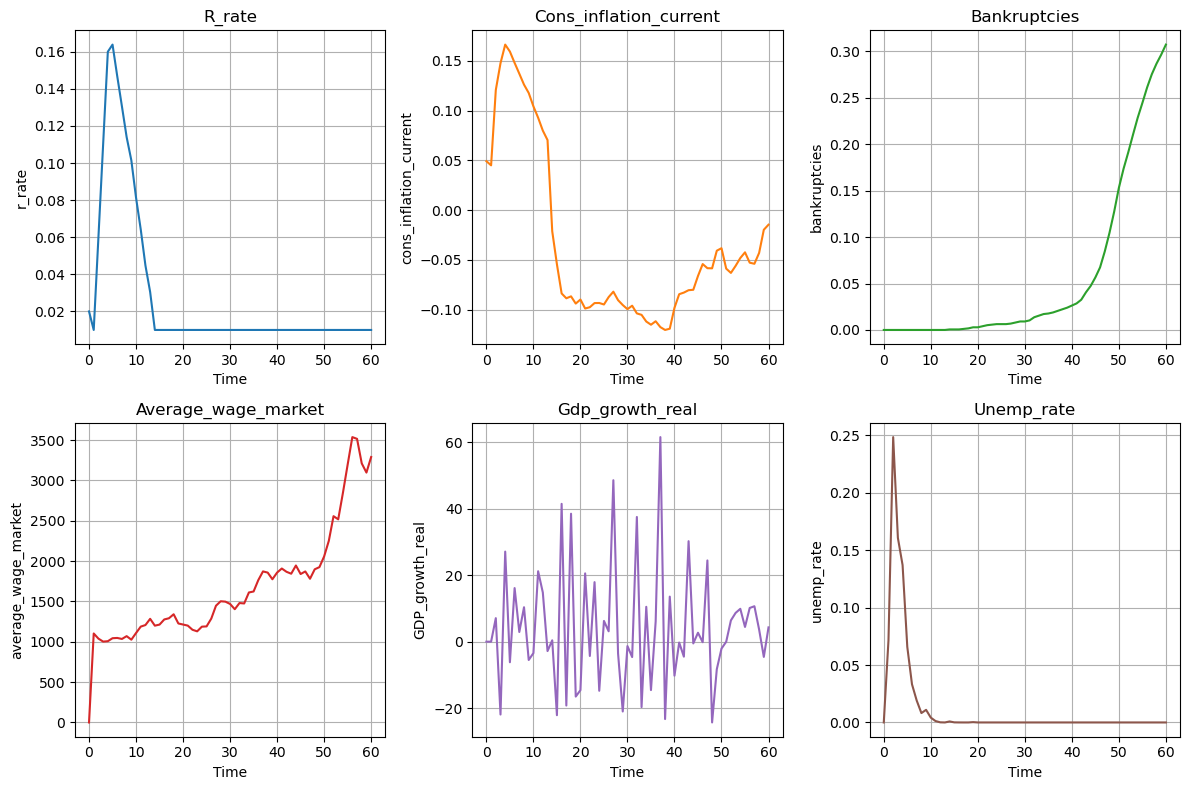

In [96]:
plot_columns(2, f"{path}\summary_plot_1_{test}",
 bank, "r_rate", 
 bank, "cons_inflation_current",
  pboard, "bankruptcies",
# pboard, "unemp_rate",
pboard, "average_wage_market", 
economy, "GDP_growth_real",
pboard, "unemp_rate")